In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as opt 
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader, Dataset


from mancala.agents import Human
from mancala.game.play import Game

In [87]:
df = pd.read_parquet('../mancala/data/RandomBot_GreedyBot_10k_clean.parquet')
df = df.loc[df['player'] == 0]

In [88]:
class MyRegression(nn.Module):
    def __init__(self, k, hidden):
        super().__init__()
        self.linear1 = nn.Linear(k, hidden * 2)
        self.linear2 = nn.Linear(hidden * 2, hidden)
        self.linear_last = nn.Linear(hidden, 6)

    def forward(self, x_in):
        hidden = F.relu(self.linear1(x_in))
        hidden = F.relu(self.linear2(hidden))
        return self.linear_last(hidden)

In [89]:
regressor = MyRegression(k=14, hidden=50)

In [90]:
class DataSet(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, idx):
        item = df.iloc[idx]
        output = {'state': torch.FloatTensor(item['BoardState']), 'reward' : item['ewma_reward'], 'action': item['action']}
        return output
    
    def __len__(self):
        return df.shape[0]

In [91]:
data = DataSet(df=df)

In [106]:
dataloader = DataLoader(data, batch_size=128, shuffle=True, num_workers=5)

In [93]:
def transform_y(actions, y, y_hat):
    vector_output = y_hat.clone()
    for index, action, true_value in zip(range(len(y)), actions, y):
        vector_output[index][action-1] = true_value
    return vector_output

In [109]:
batch = next(iter(dataloader))
losses = [np.nan]

In [119]:
# Try to overfit on certain batches
loss_func = torch.nn.L1Loss()
optimizer = opt.SGD(regressor.parameters(), lr=0.01)
epochs = 20


for i in tqdm(range(epochs)):
    batch_idx = 0
    for batch_idx, batch in enumerate(tqdm(dataloader, leave=False, desc=f'Loss: {losses[-1]}')):
        if batch_idx < 10:
            pass
        else:
            x = batch['state']
            y = batch['reward']
            actions = batch['action']

            y_hat = regressor(x)
            y_transformed = transform_y(actions, y, y_hat)
            loss = loss_func(y_hat, y_transformed)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


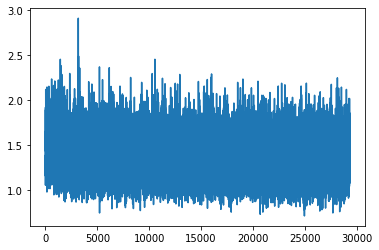

In [122]:
plt.plot(losses)

In [116]:
torch.save(regressor, 'model_Greedy_vs_Random.pth')

/Users/sander/Code/mancala/venv/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MyRegression. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [117]:
regr = torch.load('notebooks/model_Greedy_vs_Random.pth')
p1 = Human(name="John", number=0)
p2 = Human(name="Claire", number=1)
game = Game(p1, p2, num_stones=4)

In [10]:
df['BoardState'][0]

array([4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 0])

In [14]:
np.array(p1.current_game.board_state)

array([4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 0])

In [16]:
regr(torch.FloatTensor(p1.current_game.board_state))

tensor([-5.0518, -2.8010, -4.6657, -3.5199, -4.4087, -4.7916],
       grad_fn=<AddBackward0>)

In [12]:
regr(torch.FloatTensor(df['BoardState'][1]))

tensor([ 6.2078e+00,  4.8259e+00, -5.9199e-03,  5.6166e+00,  3.9525e+00,
        -2.5271e+00], grad_fn=<AddBackward0>)

In [16]:
np.argmax(regr(x).detach().numpy(), axis=1) + 1

array([6, 3, 1, 2, 6, 2, 6, 2, 6, 2, 2, 2, 2, 3, 3, 4, 3, 2, 5, 2, 6, 6,
       2, 2, 6, 1, 1, 6, 2, 2, 6, 5, 2, 2, 2, 2, 2, 3, 2, 5, 6, 2, 2, 1,
       2])